In [22]:
from bs4 import BeautifulSoup 
import requests

url = "https://hilalprp.com.om/"

# Add headers to mimic a real browser
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36"
}

# Make the request with headers
results = requests.get(url, headers=headers)

# Parse the HTML using BeautifulSoup
soup = BeautifulSoup(results.text, "html.parser")

# Print a preview of the HTML (first 500 characters)
print(results.text[:500])  # Optional: print just part to avoid long output


<!doctype html>
<html lang="en-US">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=no">
    <link rel="profile" href="http://gmpg.org/xfn/11">
    <meta name="format-detection" content="telephone=no">
	<title>Hilal Properties &#8211; Real estate agency in Oman, freehold apartments, townhouses, villas available at Sultan Haithem city</title>
<meta name='robots' content='max-image-preview:large' />
<link 


## Web scraping for Hilal Properties 

In [24]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import numpy as np

base_url = "https://hilalprp.com.om/properties-search/"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36"
}

properties = []

for page in range(1, 8):  # Pages 1 to 7
    print(f"Scraping page {page}...")
    params = {"status": "for-sale", "page": page}
    res = requests.get(base_url, headers=headers, params=params)
    soup = BeautifulSoup(res.text, "html.parser")
    
    cards = soup.find_all("article", class_="rh_list_card")
    if not cards:
        print(" No listings found on this page. Stopping.")
        break

    for card in cards:
        try:
            title_tag = card.find("h3").find("a")
            title = title_tag.text.strip()
            link = title_tag["href"].strip()
            price = card.find("p", class_="price").text.strip()

            def get_meta_value(label):
                block = card.find("span", string=label)
                if block:
                    value = block.find_next("span", class_="figure")
                    return value.text.strip() if value else None
                return None

            bedrooms = int(get_meta_value("Bedrooms") or 0)
            bathrooms = int(get_meta_value("Bathrooms") or 0)
            area = float(get_meta_value("Area") or 0)
            garage = get_meta_value("Garage") or "N/A"

            # Fetch detail page to extract location
            detail_res = requests.get(link, headers=headers)
            detail_soup = BeautifulSoup(detail_res.text, "html.parser")

            # Try extract location from breadcrumb links
            location_city = "N/A"
            city_tag = detail_soup.find("a", href=lambda href: href and "property-city" in href)
            if city_tag:
                location_city = city_tag.text.strip()

            properties.append({
                "title": title,
                "price": price,
                "bedrooms": bedrooms,
                "bathrooms": bathrooms,
                "area": area if area > 0 else np.nan,
                "garage": garage,
                "location_city": location_city,
                "url": link
            })

        except Exception as e:
            print(f" Error processing card: {e}")
            continue

    time.sleep(1)

# Step 1: Save raw data
df = pd.DataFrame(properties)
df.to_csv("hilal_raw.csv", index=False)

Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...


## Clean Data and Feature Engineering for Hilal web

In [25]:
# Clean price
df['price_clean'] = (
    df['price']
    .str.replace('OMR', '', regex=False)
    .str.replace(',', '', regex=False)
    .str.strip()
    .astype(float)
)

#  Clean garage
df['garage_clean'] = df['garage'].str.lower().str.strip()

#  Feature engineering
df['room_count'] = df['bedrooms'] + df['bathrooms']
df['price_per_m2'] = df['price_clean'] / df['area']
df['price_per_m2'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing area using median per room
median_area_per_room = (df['area'] / df['room_count']).median()
df['area_filled'] = df['area']
df.loc[df['area'].isna(), 'area_filled'] = df['room_count'] * median_area_per_room

#  One-hot encode garage
garage_dummies = pd.get_dummies(df['garage_clean'], prefix='garage')
df = pd.concat([df, garage_dummies], axis=1)

#  drop raw columns if not needed
df.drop(columns=['price', 'garage', 'area'], inplace=True)

# Save final cleaned data
df.to_csv("hilal_cleaned.csv", index=False)
print(f"✅ Saved cleaned and enhanced dataset with {len(df)} listings.")

✅ Saved cleaned and enhanced dataset with 70 listings.


C:\Users\bbuser\AppData\Local\Temp\ipykernel_3876\9589099.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price_per_m2'].replace([np.inf, -np.inf], np.nan, inplace=True)


## Feature Engineering Halil propraties and Predictive Modeling 

        bedrooms  bathrooms    price_clean  room_count  price_per_m2  \
count  70.000000  70.000000      70.000000   70.000000     21.000000   
mean    5.200000   6.500000  108110.000000   11.700000    295.572248   
std     1.547321   1.924292  108234.176378    3.431947     89.341289   
min     3.000000   3.000000     180.000000    6.000000    183.246073   
25%     4.000000   5.000000     700.000000    9.000000    183.246073   
50%     5.500000   7.000000   80000.000000   12.500000    307.692308   
75%     7.000000   8.000000  180000.000000   15.000000    395.778364   
max     7.000000   9.000000  300000.000000   16.000000    395.778364   

       area_filled  
count    70.000000  
mean    453.240000  
std     163.376768  
min     229.200000  
25%     267.400000  
50%     477.500000  
75%     573.000000  
max     758.000000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------  

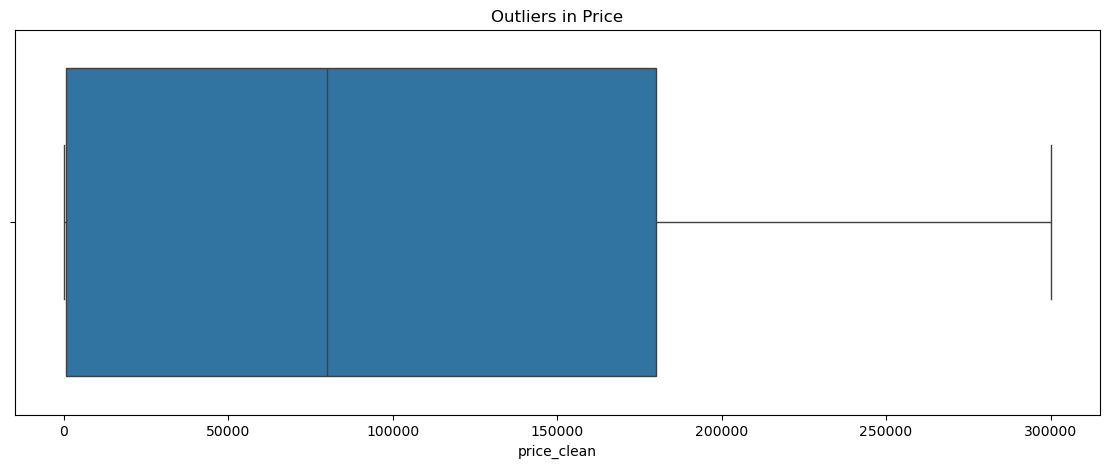

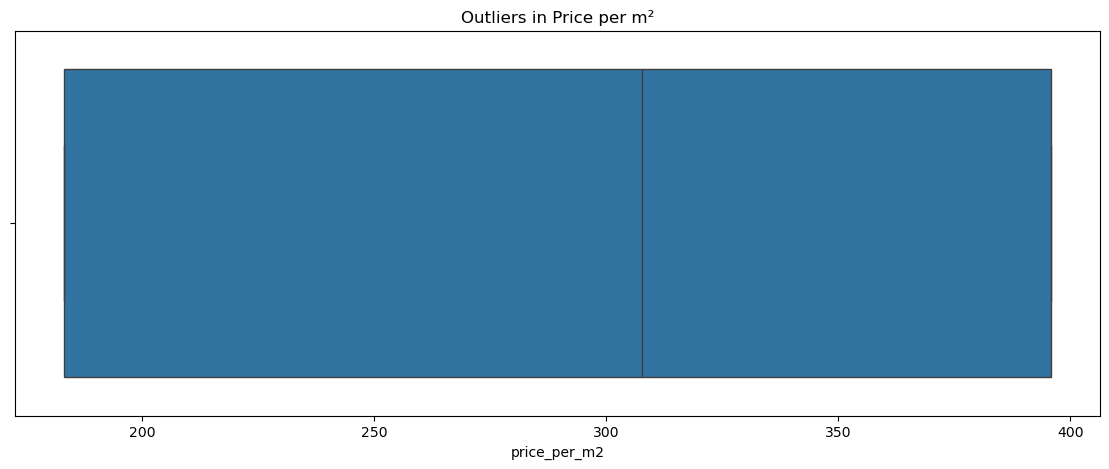

Missing values in features:
 bedrooms               0
bathrooms              0
room_count             0
area_filled_scaled     0
price_per_m2_scaled    0
garage_outside         0
garage_shaded          0
garage_unshaded        0
dtype: int64
Linear Regression - MSE: 6035646896.54, R2: 0.42
Decision Tree - MSE: 1851545184.65, R2: 0.82
Random Forest - MSE: 1827485764.51, R2: 0.82


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


df = pd.read_csv("hilal_cleaned.csv")

#  EDA - Check summary
print(df.describe())
print(df.info())

# Visualize outliers
plt.figure(figsize=(14, 5))
sns.boxplot(x=df['price_clean'])
plt.title("Outliers in Price")
plt.show()

plt.figure(figsize=(14, 5))
sns.boxplot(x=df['price_per_m2'])
plt.title("Outliers in Price per m²")
plt.show()

# Feature Engineering & Imputation of missing price_per_m2
# Impute missing price_per_m2 with median per city
df['price_per_m2'] = df.groupby('location_city')['price_per_m2'].transform(lambda x: x.fillna(x.median()))
# Fill remaining NaNs with overall median
df['price_per_m2'] = df['price_per_m2'].fillna(df['price_per_m2'].median())

# Scale numerical features after imputation
scaler = StandardScaler()
df[['price_per_m2_scaled', 'area_filled_scaled']] = scaler.fit_transform(df[['price_per_m2', 'area_filled']])

# Optional: drop rows with missing price_clean or area_filled (should be none or very few)
df = df.dropna(subset=['price_clean', 'area_filled'])

#  Prepare data for modeling
# Only boolean garage columns (exclude garage_clean string column)
garage_cols = [col for col in df.columns if col.startswith('garage_') and col != 'garage_clean']

features = ['bedrooms', 'bathrooms', 'room_count', 'area_filled_scaled', 'price_per_m2_scaled'] + garage_cols

X = df[features]
y = df['price_clean']


print("Missing values in features:\n", X.isnull().sum())

#  Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training and evaluation

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")



In [33]:
garage_cols = [col for col in df.columns if col.startswith('garage_')]
print(garage_cols)
print(df[garage_cols].dtypes)
df.shape



['garage_clean', 'garage_outside', 'garage_shaded', 'garage_unshaded']
garage_clean       object
garage_outside       bool
garage_shaded        bool
garage_unshaded      bool
dtype: object


(56, 15)

## web scraping for dubizzle propraties 

In [34]:
pip install selenium beautifulsoup4 pandas


Note: you may need to restart the kernel to use updated packages.


In [35]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from bs4 import BeautifulSoup
import csv
import time

# Setup WebDriver options
options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
# Set user-agent to mimic a real browser
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                     "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36")

driver = webdriver.Chrome(options=options)

wait = WebDriverWait(driver, 10)
base_url = "https://www.dubizzle.com.om/en/properties/properties-for-sale/?page={}"
data = []

for page in range(1, 105):
    print(f"Scraping page {page}...")
    driver.get(base_url.format(page))

    try:
        # Wait until at least one listing is present
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "article._63a946ba")))
    except TimeoutException:
        print(f"No listings found on page {page}, stopping scraping.")
        break

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    listings = soup.find_all("article", class_="_63a946ba")
    print(f"Listings found on page {page}: {len(listings)}")

    if not listings:
        print("No more listings found.")
        break

    for listing in listings:
        try:
            title = listing.find("h2", class_="_562a2db2").get_text(strip=True)
            location = listing.find("span", {"aria-label": "Location"}).get_text(strip=True)
            price = listing.find("div", {"aria-label": "Price"}).get_text(strip=True)

            subtitle = listing.find("div", {"aria-label": "Subtitle"})
            spans = subtitle.find_all("span", class_="_3e1113f0") if subtitle else []

            rooms = spans[0].text.strip() if len(spans) > 0 else "N/A"
            baths = spans[1].text.strip() if len(spans) > 1 else "N/A"
            size = spans[2].text.strip() if len(spans) > 2 else "N/A"

            data.append({
                "Title": title,
                "Location": location,
                "Price": price,
                "Rooms": rooms,
                "Bathrooms": baths,
                "Size": size
            })
        except Exception as e:
            print("Error parsing a listing:", e)
            continue

    # Be polite, random sleep to reduce risk of blocking
    time.sleep(2)

driver.quit()

# Save to CSV
csv_filename = "dubizzle_all_pagess.csv"
with open(csv_filename, "w", newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=["Title", "Location", "Price", "Rooms", "Bathrooms", "Size"])
    writer.writeheader()
    writer.writerows(data)

print(f"✅ Scraped {len(data)} total listings into {csv_filename}")


Scraping page 1...
Listings found on page 1: 45
Scraping page 2...
Listings found on page 2: 45
Scraping page 3...
Listings found on page 3: 45
Scraping page 4...
Listings found on page 4: 45
Scraping page 5...
Listings found on page 5: 45
Scraping page 6...
Listings found on page 6: 45
Scraping page 7...
Listings found on page 7: 45
Scraping page 8...
Listings found on page 8: 45
Scraping page 9...
Listings found on page 9: 45
Scraping page 10...
Listings found on page 10: 45
Scraping page 11...
Listings found on page 11: 45
Scraping page 12...
Listings found on page 12: 45
Scraping page 13...
Listings found on page 13: 45
Scraping page 14...
Listings found on page 14: 45
Scraping page 15...
Listings found on page 15: 45
Scraping page 16...
Listings found on page 16: 45
Scraping page 17...
Listings found on page 17: 45
Scraping page 18...
Listings found on page 18: 45
Scraping page 19...
Listings found on page 19: 45
Scraping page 20...
Listings found on page 20: 45
Scraping page 21..

In [45]:
import pandas as pd

df_dubizzle = pd.read_csv("dubizzle_all_pagess.csv")
print(" Column names in file:")
print(df_dubizzle.columns.tolist())



 Column names in file:
['Title', 'Location', 'Price', 'Rooms', 'Bathrooms', 'Size']


In [38]:
print("Dubizzle columns:", df_dubizzle.columns.tolist())
print("Hilal columns:", df_hilal.columns.tolist())


Dubizzle columns: ['title', 'location', 'price', 'rooms', 'bathrooms', 'area_sqm']
Hilal columns: ['title', 'bedrooms', 'bathrooms', 'location_city', 'url', 'price_clean', 'garage_clean', 'room_count', 'price_per_m2', 'area_filled', 'garage_outside', 'garage_shaded', 'garage_unshaded']


## Data cleaning and feature Engineering for dubizzle 

In [49]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


df = pd.read_csv("dubizzle_all_pagess.csv")


df.drop_duplicates(inplace=True)


for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna("N/A")


df.rename(columns={
    "Title": "title",
    "Location": "location",
    "Price": "price",
    "Rooms": "rooms",
    "Bathrooms": "bathrooms",
    "Size": "area_sqm"
}, inplace=True)


df["price"] = (
    df["price"].astype(str)
    .str.replace(",", "")
    .str.extract(r"(\d+)", expand=False)
)
df["area_sqm"] = (
    df["area_sqm"].astype(str)
    .str.replace(",", "")
    .str.extract(r"(\d+)", expand=False)
)

df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["area_sqm"] = pd.to_numeric(df["area_sqm"], errors="coerce")

# Step 5: Convert rooms and bathrooms to numeric, extracting digits
df["rooms"] = pd.to_numeric(
    df["rooms"].astype(str).str.extract(r"(\d+)", expand=False), errors="coerce"
)
df["bathrooms"] = pd.to_numeric(
    df["bathrooms"].astype(str).str.extract(r"(\d+)", expand=False), errors="coerce"
)

# Drop rows with missing price or area_sqm
df.dropna(subset=["price", "area_sqm"], inplace=True)

#  Feature engineering
df["price_per_sqm"] = df["price"] / df["area_sqm"]
df["total_rooms"] = df["rooms"].fillna(0) + df["bathrooms"].fillna(0)

# One-hot encode location column
df = pd.get_dummies(df, columns=["location"], drop_first=True)

# Scale numeric features
scaler = StandardScaler()
features_to_scale = ["price", "area_sqm", "price_per_sqm", "total_rooms"]
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

#  Save cleaned and feature-engineered dataset
df.to_csv("dubizzle_feature_engineered.csv", index=False)

print(f" Dataset processed and saved: {df.shape[0]} rows, {df.shape[1]} columns.")




 Dataset processed and saved: 2091 rows, 72 columns.


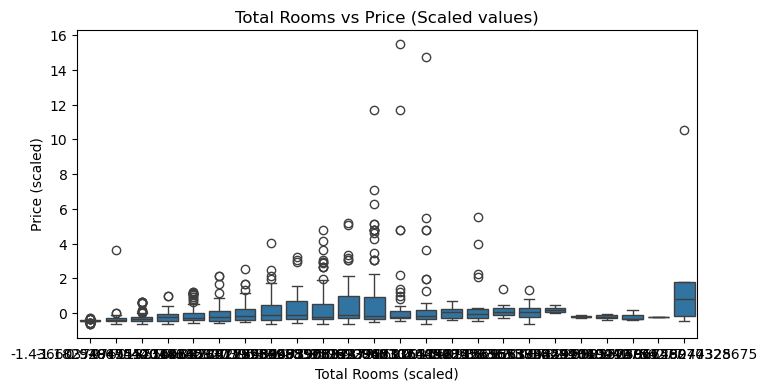

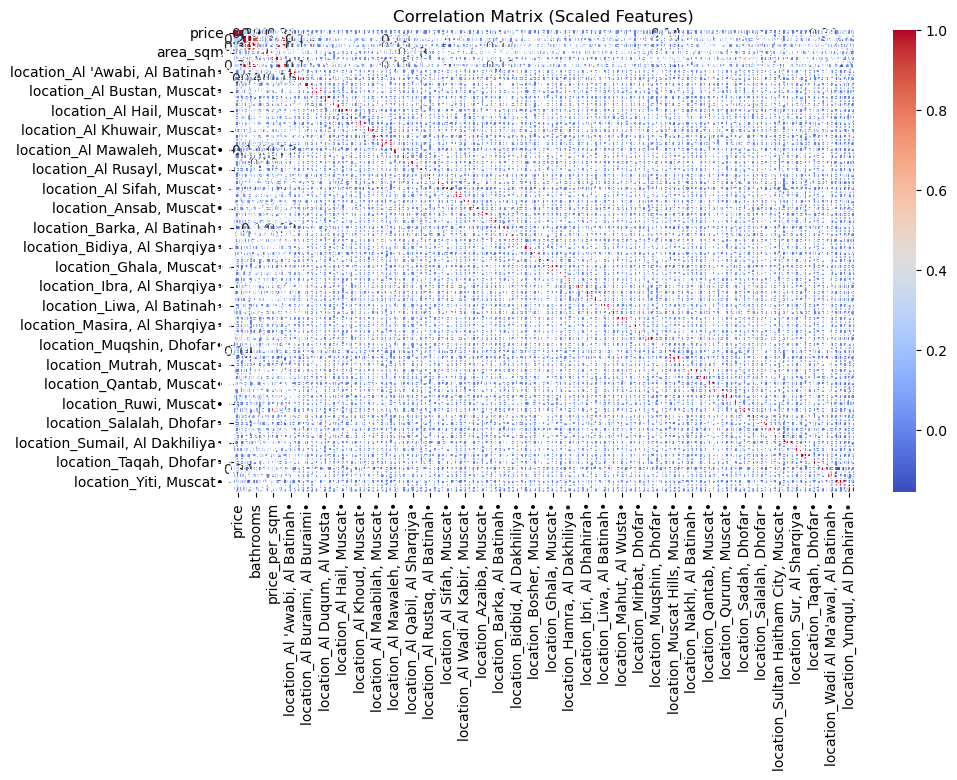

In [55]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["total_rooms"], y=df["price"])
plt.title("Total Rooms vs Price (Scaled values)")
plt.xlabel("Total Rooms (scaled)")
plt.ylabel("Price (scaled)")
plt.show()

# Correlation heatmap of numeric features (scaled)
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Scaled Features)")
plt.show()



In [58]:
print(df.columns.tolist())


['title', 'price', 'rooms', 'bathrooms', 'area_sqm', 'price_per_sqm', 'total_rooms', "location_Al 'Awabi, Al Batinah•", 'location_Al Amarat, Muscat•', 'location_Al Buraimi, Al Buraimi•', 'location_Al Bustan, Muscat•', 'location_Al Duqum, Al Wusta•', 'location_Al Ghubrah, Muscat•', 'location_Al Hail, Muscat•', 'location_Al Khaboura, Al Batinah•', 'location_Al Khoud, Muscat•', 'location_Al Khuwair, Muscat•', 'location_Al Maabilah, Muscat•', "location_Al Masn'a, Al Batinah•", 'location_Al Mawaleh, Muscat•', 'location_Al Mudaibi, Al Sharqiya•', 'location_Al Qabil, Al Sharqiya•', 'location_Al Rusayl, Muscat•', 'location_Al Rustaq, Al Batinah•', 'location_Al Seeb, Muscat•', 'location_Al Sifah, Muscat•', 'location_Al Sinainah, Al Buraimi•', 'location_Al Wadi Al Kabir, Muscat•', 'location_Ansab, Muscat•', 'location_Azaiba, Muscat•', 'location_Bahla, Al Dakhiliya•', 'location_Barka, Al Batinah•', 'location_Barr Al Jissah, Muscat•', 'location_Bidbid, Al Dakhiliya•', 'location_Bidiya, Al Sharqiya

## Predictive Modeling for dubizzle:

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the cleaned & feature-engineered dataset
df = pd.read_csv("dubizzle_feature_engineered.csv")

# Columns of your dataset (adjust if needed)
# Here, 'price' is target, rest are features (excluding 'title' which is text)
target_col = "price"

# List features: drop 'title' (text) and keep rest numeric & one-hot encoded columns
feature_cols = [col for col in df.columns if col not in ['title', target_col]]

# Drop rows with missing values in features or target
df_clean = df.dropna(subset=feature_cols + [target_col])

# Separate features and target
X = df_clean[feature_cols]
y = df_clean[target_col]

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Train, predict, and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")


Linear Regression - MSE: 0.58, R2: -0.07
Decision Tree - MSE: 0.07, R2: 0.88
Random Forest - MSE: 0.04, R2: 0.93


## Combaine Combined all cleaned datasets :

In [68]:
import pandas as pd

# Load datasets
df_dubizzle = pd.read_csv("dubizzle_feature_engineered.csv")
df_hilal = pd.read_csv("hilal_cleaned.csv")

# Rename Hilal columns to match Dubizzle naming
df_hilal.rename(columns={
    'price_clean': 'price',
    'room_count': 'rooms',
    'area_filled': 'area_sqm',
    'location_city': 'location',
    'bathrooms': 'bathrooms',  # already matching
    'title': 'title'
}, inplace=True)

# Add missing columns in Hilal with default values if needed
if 'price_per_sqm' not in df_hilal.columns:
    df_hilal['price_per_sqm'] = df_hilal['price'] / df_hilal['area_sqm']

if 'total_rooms' not in df_hilal.columns:
    df_hilal['total_rooms'] = df_hilal['rooms']  # or calculate if you have other room counts

# Prepare Dubizzle simple dataset with location dummy columns
common_cols = ['title', 'price', 'rooms', 'bathrooms', 'area_sqm', 'price_per_sqm', 'total_rooms']
dubizzle_location_cols = [col for col in df_dubizzle.columns if col.startswith('location_')]
df_dubizzle_simple = df_dubizzle[common_cols + dubizzle_location_cols]

# One-hot encode Hilal location
location_dummies = pd.get_dummies(df_hilal['location'], prefix='location')

# Prepare Hilal simple dataset by concatenating features and location dummies
df_hilal_simple = pd.concat([df_hilal[common_cols], location_dummies], axis=1)

# Align columns so both datasets have the same columns, fill missing with 0
df_hilal_simple, df_dubizzle_simple = df_hilal_simple.align(df_dubizzle_simple, join='outer', axis=1, fill_value=0)

# Combine vertically
combined_df = pd.concat([df_dubizzle_simple, df_hilal_simple], ignore_index=True)

# Save combined dataset
combined_df.to_csv("combined_dubizzle_hilal_cleaned.csv", index=False)

print(f"Combined dataset saved with {combined_df.shape[0]} rows and {combined_df.shape[1]} columns.")


Combined dataset saved with 2161 rows and 78 columns.


In [67]:
print(df_hilal.columns.tolist())


['title', 'bedrooms', 'bathrooms', 'location_city', 'url', 'price_clean', 'garage_clean', 'room_count', 'price_per_m2', 'area_filled', 'garage_outside', 'garage_shaded', 'garage_unshaded']


## Predictive Model for Combaine datasets:

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load combined cleaned data
df = pd.read_csv("combined_dubizzle_hilal_cleaned.csv")

# Drop rows with missing target price
df = df.dropna(subset=['price'])

# Drop 'title' column (non-numeric, text)
if 'title' in df.columns:
    df = df.drop(columns=['title'])

# Drop rows with any remaining NaN (or alternatively, you can impute)
df = df.dropna()

# Separate features and target
X = df.drop(columns=['price'])
y = df['price']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to test
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100)
}

# Train, predict and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} -> MSE: {mse:.2f}, R2: {r2:.3f}")


Linear Regression -> MSE: 1206612.15, R2: 0.998
Decision Tree -> MSE: 0.18, R2: 1.000
Random Forest -> MSE: 150431.10, R2: 1.000


## Visuallization 

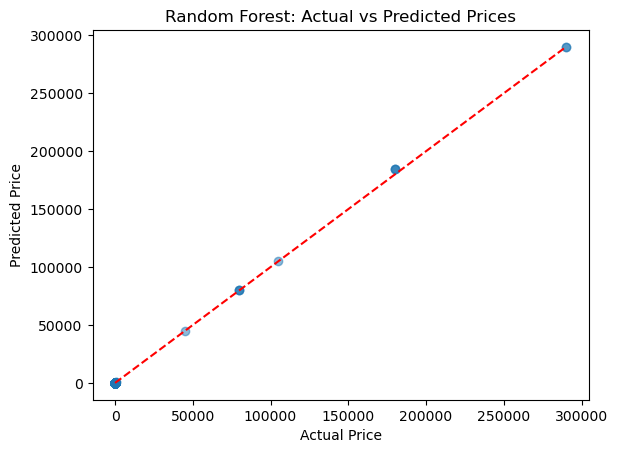

In [70]:
import matplotlib.pyplot as plt

model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)
preds = model.predict(X_test)

plt.scatter(y_test, preds, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest: Actual vs Predicted Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # identity line
plt.show()
